PROGETTO DI FONDAMENTI DI INTELLIGENZA ARTIFICIALE

Questo progetto si pone come obiettivo la creazione di una rete neurale con lo scopo di distinguere il genere dei libri dalla loro copertina. 
Il dataset utilizzato per la creazione del modello della rete neurale è stato preso da kaggle (https://www.kaggle.com/lukaanicin/book-covers-dataset) dandoci a disposizione 33 generi diversi di libri e circa 900 copertine per ognuno di essi consentendoci di avere un dataset di una mole più che adeguata su cui lavorare. 

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, \
preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Input,Flatten,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Naturalmente per poter lavorare tramite i notebook di google colab abbiamo caricato il dataset su Google Drive ed effettuato il mounting del drive all' interno del notebook per poter far vedere le immagini alla rete neurale

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Prendiamo i path che conducono alle cartelle apposite che abbiamo creato in precedenza rispettando la proporzione di 80% degli elementi che formano il training set ed il 20% per il validation set

In [ ]:
train_path ='gdrive/MyDrive/ProgettoFIA/data/train'
valid_path ='gdrive/MyDrive/ProgettoFIA/data/test'

E dal path delle cartelle prendiamo il path per i singoli elementi

In [ ]:
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

Ma per evitare l' utilizzo di troppe risorse che non avevamo a nostra disposizione e per via della mole di immagini che rendeva troppo lento il caricamento del dataset abbiamo deciso di selezionare 5 generi.

In [ ]:
folders = glob(train_path + '/*')
folders

['gdrive/MyDrive/ProgettoFIA/data/train/Childrens-Books_0',
 'gdrive/MyDrive/ProgettoFIA/data/train/Computing_1',
 'gdrive/MyDrive/ProgettoFIA/data/train/Crime-Thriller_2',
 'gdrive/MyDrive/ProgettoFIA/data/train/Natural-History_3',
 'gdrive/MyDrive/ProgettoFIA/data/train/Transport_4']

Tutte le immagini sono state ridimensionate per avere una dimensione unica per tutte quante le immagini e permettere di avere uno shape unico di input da dare alla rete neurale 

In [ ]:
IMAGE_SIZE = [100, 100]

Sfortunatamente in precedenti test su una rete neurale completamente di nostra creazione i risultati ottenuti erano insoddisfacenti e quindi per ottimizzare i risultati abbiamo deciso di sfruttare il transfer learning. 

Cioè usare una rete neurale convoluzionale preaddestrata, la rete VGG16, inclusa nella libreria di keras.


Abbiamo diviso il modello in due parti per poter allenare solo gli ultimi layer che permettono la classificazione in generi  e ridurre il carico computazionale.

In [ ]:
ptm = PretrainedModel(
    include_top = False,
    weights='imagenet',
    input_shape=IMAGE_SIZE + [3])

58892288/58889256 [==============================] - 0s 0us/step


Ma avere solo gli strati di convoluzione non ci aiuta, per cui dobbiamo aggiungere uno strato di Flatten per poter prendere l'output di questo modello ed unirlo ad una serie di strati Dense per poter avere una predizione riguardante il genere dei libri le cui copertine verranno usate come input

In [ ]:
x = Flatten()(ptm.output)

Per cui indichiamo al modello di prendere in input le immagini delle copertine e di restituire in output il risultato del Flatten

In [ ]:
model = Model(inputs=ptm.input, outputs=x)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

Per dare le informazioni  delle copertine nella seconda parte della rete neurale utilizziamo ImageDataGenerator per creare i "generatori" di immagini dal train e dal validation set, che  caricheranno i dati dalle cartelle corrispondenti dove il batch size corrisponde a quanti elementi verranno presi ad ogni elaborazione

In [ ]:
gen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

In [ ]:
batch_size = 300

In [ ]:
train_generator = gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = gen.flow_from_directory(
    valid_path,
    target_size = IMAGE_SIZE,
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 3949 images belonging to 5 classes.
Found 990 images belonging to 5 classes.


Qui prendiamo il numero delle immagini del training e del validation set e lo shape delle loro feature 

In [ ]:
Ntrain = len(image_files)
Nvalid = len(valid_image_files)

feat = model.predict(np.random.random([1] + IMAGE_SIZE + [3]))
D = feat.shape[1]

Questa funzione crea degli array pieni di zeri prendendo come input il numero di immagini e lo shape delle feature per creare gli array delle x, mentre l'array delle y richiede il numero delle immagini ed il numero di generi su cui lavoreremo

In [ ]:
def create_Xy (Nset,D,i):

  X=np.zeros((Nset,D))
  y=np.zeros((Nset,i))

  return X,y

In [ ]:
X_train, Y_train =create_Xy(Ntrain,D,5)

In [ ]:
X_valid, Y_valid =create_Xy(Nvalid,D,5)

Quest' altra funzione prende gli array creati precedentemente e li sovrascrive con i dati delle copertine fino a quando non abbiamo tutte le copertine

In [ ]:
def create_set(generator,X_set,Y_set,Nset):
  i = 0
  for x, y in generator:
    features = model.predict(x)
    sz = len(y)
    X_set[i:i + sz] = features
    Y_set[i:i + sz] = y

    i += sz
    print(i)
    if i >= Nset:
      print('breaking now')
      break

  print(i)


In [ ]:
create_set(train_generator,X_train,Y_train,Ntrain)

In [ ]:
create_set(valid_generator, X_valid, Y_valid,Nvalid)

L'input di questo modello corrisponde allo shape delle feature ed all'output dell Flatten del modello precedente.

In questo secondo modello non usiamo solamente layer di Dense ma anche layer di Dropout per avere delle predizioni più precise del 3% e dei valori di validation loss non eccessivamente al di sopra il training loss.


In [ ]:
i = Input(shape=(D,))

x=Dropout(0.5)(i)
x = Dense(256, activation='relu')(x)
x=Dropout(0.1)(x)
x = Dense(256, activation='relu')(x)
x=Dropout(0.1)(x)
x = Dense(256, activation='relu')(x)
x=Dropout(0.1)(x)
x = Dense(512, activation='relu')(x)
x=Dropout(0.1)(x)
x = Dense(512, activation='relu')(x)
x=Dropout(0.1)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.1)(x)
x = Dense(1024, activation='relu')(x)
x=Dropout(0.1)(x)
x = Dense(5, activation='softmax')(x)

linear_model = Model(i, x)

In [ ]:
linear_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
r = linear_model.fit(
    X_train,
    Y_train,
    validation_data = (X_valid, Y_valid),
    epochs = 20,
    batch_size = 300                  
)

Di seguito mostriamo i grafici di loss ed accuratezza con e senza Dropout della rete neurale

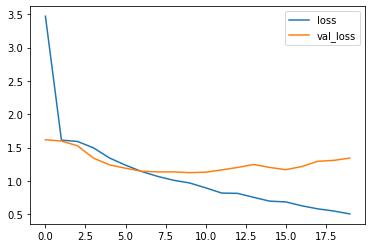

In [ ]:
#con Dropout
#Epoch 1/20
# loss: 4.9555 - val_loss: 1.6170
#Epoch 16/20
# loss: 0.6642 - val_loss: 1.1679
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()

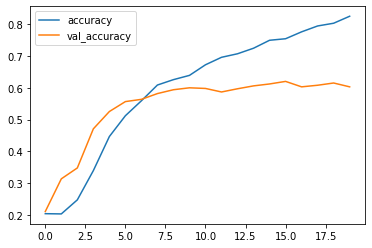

In [ ]:
#con Dropout
#Epoch 1/20
# accuracy: 0.2025 - val_accuracy: 0.2101
#Epoch 16/20
# accuracy: 0.7575 - val_accuracy: 0.6202
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.legend()

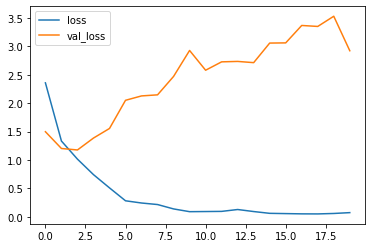

In [ ]:
#senza Dropout
#Epoch 1/20
# loss: 2.9654 - val_loss: 1.4973
#Epoch 20/20
# loss: 0.0614 -  val_loss: 2.9242
plt.plot(r.history["loss"], label="loss")
plt.plot(r.history["val_loss"], label="val_loss")
plt.legend()

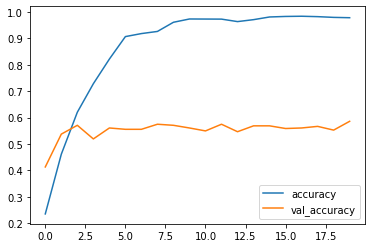

In [ ]:
#senza Dropout
#Epoch 1/20
# accuracy: 0.2203 - val_accuracy: 0.4131
#Epoch 20/20
# accuracy: 0.9809 - val_accuracy: 0.5859
plt.plot(r.history["accuracy"], label="accuracy")
plt.plot(r.history["val_accuracy"], label="val_accuracy")
plt.legend()

Questa rappresentazione grafica rappresenta la confusion matrix, una matrice che permette di esaminare quante immagini sono state categorizzate in maniera precisa e quanti elementi di un singolo genere siano stati erroneamente categorizzati in un altro, dove gli indici che usiamo corrispondono ai numeri scelti nei nomi delle cartelle dei generi.

In [7]:
model = tf.keras.models.load_model('gdrive/MyDrive/ProgettoFIA/Modello5generi')
linear_model = tf.keras.models.load_model('gdrive/MyDrive/ProgettoFIA/modello_linear')

Confusion matrix, without normalization
[[125  14  25  19  15]
 [ 19 122  18  25  14]
 [ 20  24 125  16  13]
 [ 37  32  16  97  16]
 [ 14  26  17  11 130]]


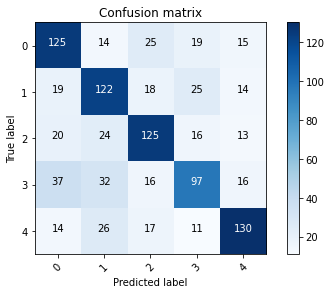

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  Normalizazione può essere applicata dal setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

p_test = linear_model.predict(X_valid).argmax(axis=1)
Y=Y_valid.argmax(axis=1)
cm = confusion_matrix(Y, p_test)
plot_confusion_matrix(cm, folders))

In [ ]:
folders

['gdrive/MyDrive/ProgettoFIA/data/train/Childrens-Books_0',
 'gdrive/MyDrive/ProgettoFIA/data/train/Computing_1',
 'gdrive/MyDrive/ProgettoFIA/data/train/Crime-Thriller_2',
 'gdrive/MyDrive/ProgettoFIA/data/train/Natural-History_3',
 'gdrive/MyDrive/ProgettoFIA/data/train/Transport_4']

Alla fine di tutto salviamo i nostri due modelli per poterli riutilizzare nella web app creata per testare la rete neurale 

In [ ]:
model.save('gdrive/MyDrive/ProgettoFIA/Modello5generi')

INFO:tensorflow:Assets written to: gdrive/MyDrive/ProgettoFIA/Modello5generi/assets


In [ ]:
linear_model.save('gdrive/MyDrive/ProgettoFIA/Modello5generi/modello_linear')

INFO:tensorflow:Assets written to: gdrive/MyDrive/ProgettoFIA/Modello5generi/modello_linear/assets


Di seguito un piccolo esempio che prende un immagine casuale dal nostro dataset

In [ ]:
Y_valid[0]

array([0., 0., 0., 0., 1.])

In [ ]:
img_sel=np.array(image.load_img(np.random.choice(image_files)))
array=[img_sel]
array=np.array(array)
array.shape

(1, 100, 100, 3)

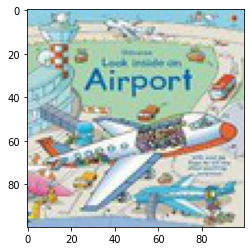

In [ ]:
plt.imshow(img_sel)

In [ ]:
sel=model.predict(array)
sel.shape

(1, 4608)

In [ ]:
linear_sel=linear_model.predict(sel)
linear_sel

array([[9.9999833e-01, 3.2477294e-07, 1.1112187e-06, 2.0387871e-07,
        3.5841989e-08]], dtype=float32)